In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

mat = scipy.io.loadmat('Downloads/510050.mat')
matsurface = scipy.io.loadmat('Downloads/510050surface.mat')
meta =  scipy.io.loadmat('Downloads/Option_Meta.mat')

In [2]:
print(mat.keys())
print(matsurface.keys())
data = meta['meta'][0][0][0][0]

dict_keys(['__header__', '__version__', '__globals__', 'date', 'code', 'amt', 'chg', 'close', 'delta', 'gamma', 'high', 'impl_vol', 'low', 'multiplier', 'oi', 'oi_chg', 'open', 'pre_close', 'pre_settle', 'rho', 'settle', 'theta', 'us_close', 'us_preclose', 'vega', 'volume'])
dict_keys(['__header__', '__version__', '__globals__', 'date', 'forward', 'repo', 'dtm', 'rf', 'ulprice', 'volByStrike', 'volByMoneyness', 'volByDelta'])


In [16]:
dtm_matrix=matsurface['dtm']*360

def near_next(dtms):
    dtms = np.array([i[0] for i in dtms[0]])
    near_term_index = np.min(np.where(dtms > 7))
    next_term_index = near_term_index+1
    near_term_dtm = dtms[near_term_index]
    next_term_dtm = dtms[next_term_index]
    return near_term_index, next_term_index, near_term_dtm, next_term_dtm
    
near_term_index_list = np.array([near_next(j)[0] for j in dtm_matrix])
next_term_index_list = np.array([near_next(j)[1] for j in dtm_matrix])
near_term_dtm_list = np.array([near_next(j)[2] for j in dtm_matrix])
next_term_dtm_list = np.array([near_next(j)[3] for j in dtm_matrix])

In [17]:
time_range = len(mat['date'])
option_range = len(mat['code'])

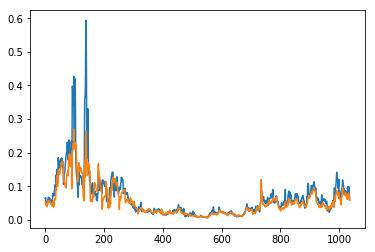

In [18]:
settle = pd.DataFrame(mat['settle'])

#create array of pc flag
pc = data[10][:option_range]
pc_array = np.array([])
for i in range(option_range):
    if pc[i][0][0] == "认沽":
        pc_array = np.append(pc_array,'put')
    else:
        pc_array = np.append(pc_array,'call')

#create array of strikes
strike_array = data[12][:time_range, :option_range][0]

#create array of option expiration dates
exp_dates = data[8][:option_range]
exp_dates_array = np.array([])
for i in range(option_range):
    exp_dates_array = np.append(exp_dates_array, datetime.datetime.strptime(exp_dates[i][0][0], "%Y/%m/%d"))

#creates array of option start dates
start_dates = data[5][:option_range]
start_dates_array = np.array([])
for i in range(option_range):
    start_dates_array = np.append(start_dates_array, datetime.datetime.strptime(start_dates[i][0][0], "%Y/%m/%d"))

#create array of history data dates
datenum = [i[0] for i in matsurface['date']]
dates = np.array([])
for i in range(time_range):
    dates = np.append(dates, datetime.datetime.fromordinal(datenum[i]-366))

#create matrix of dates to maturity    
Dtm = np.empty([time_range,option_range])
for i in range(time_range):
    for j in range(option_range):
        if dates[i] >= start_dates_array[j] and dates[i] <= exp_dates_array[j]:
            Dtm[i,j] = (exp_dates_array[j]-dates[i]).days
        else:
            Dtm[i,j] = np.NaN
Dtm = pd.DataFrame(Dtm, index = dates)

def vol(dtm_list, index_list):
    vols = np.array([])
    
    #create array of forward
    forward = matsurface['forward']
    forward_array = np.array([])
    for i in range(time_range):
        forward_array = np.append(forward_array, forward[i][0][index_list[i]])

    for day in range(time_range):
        mature_option_indices = np.where(np.array(Dtm.iloc[day,:]) == np.round(dtm_list[day]))
        final_indices = np.array([])
        for i in mature_option_indices[0]:
            if (strike_array[i] > forward_array[day] and pc_array[i] == "call"):
                final_indices= np.append(final_indices, i)
            elif(strike_array[i] < forward_array[day] and pc_array[i] == "put"):
                final_indices= np.append(final_indices, i)

        strike_list = np.argsort(strike_array[final_indices.astype(int)])
        final_indices = final_indices[strike_list]
        strikes = np.sort(strike_array[final_indices.astype(int)])
        sum = 0
        for i in range(len(strike_list)):                
            first = 0
            last = len(strike_list)-1
            if i == 0:
                delta = strikes[1]-strikes[0]
            elif i == last:
                delta = strikes[last] - strikes[last-1]
            else:
                delta = 0.5* (strikes[i+1] - strikes[i-1])
            index = final_indices[i]
            term = delta / strike_array[int(index)]**2  * settle.iloc[day,int(index)] 
            sum += term
        vols = np.append(vols,sum*2/(dtm_list[day]/360)* np.exp(0.05 * (dtm_list[day]/360)))
    return vols

near = vol(near_term_dtm_list, near_term_index_list)
next_ = vol(next_term_dtm_list, next_term_index_list)
plt.plot(near)
plt.plot(next_)
plt.show()

/Users/XO/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


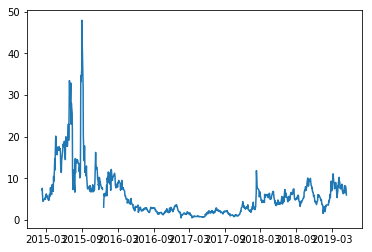

In [20]:
vix1 = 1/360 * near_term_dtm_list * near**2 * (next_term_dtm_list - 30)/(next_term_dtm_list-near_term_dtm_list)
vix2 = 1/360 * next_term_dtm_list * next_**2 * (30 - near_term_dtm_list)/(next_term_dtm_list-near_term_dtm_list)
vix = 100* ((vix1+vix2)*360/30)**0.5
plt.plot(dates,vix)
plt.show()

In [22]:
forward = matsurface['forward']
ul_array = np.array([])
for i in range(time_range):
    ul_array = np.append(ul_array, forward[i][0][near_term_index_list[i]])
ul_array

array([2.32625999, 2.36126709, 2.37867597, ..., 2.72473089, 2.71211345,
       2.77756954])

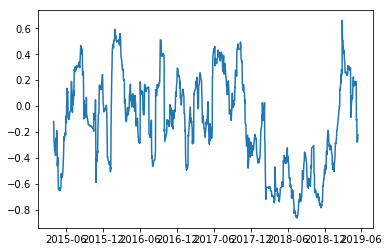

In [81]:
DF = pd.DataFrame([vix, ul_array], columns = dates, index = ["vix", "forward price"] ).transpose()

correlation = np.array([])
for i in range(time_range - 30):
    ul_pct = DF['forward price'][i:i+30].pct_change()
    vix_chg =  DF['vix'][i:i+30].diff()
    correlation = np.append(correlation, ul_pct.corr(vix_chg))
    
plt.plot(dates[30:],correlation)
#plt.plot(dates, DF['vix'].pct_change())

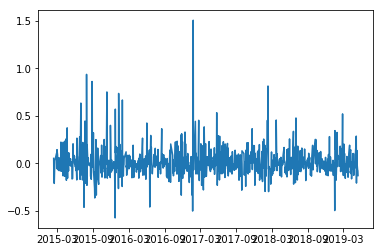

In [80]:
plt.plot(dates, DF['vix'].pct_change())